In [1]:
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn


from collections import Counter 

from tqdm.auto import tqdm

import textacy
import textacy.preprocessing as tprep

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords



from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Phrases


from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer



import seaborn as sns
from sklearn.metrics import silhouette_score


Note that the stopword will be changed manually. You may want to restart the file in case the spacy part is affected.


# 1. Data Preprocessing

In [2]:
#read file
df = pd.read_csv('rayyan_abstract2.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')]# remove the unnammed column
df.dropna(subset=['abstract'], inplace=True)

In [3]:
# make abstract sentence-case 
df['abstract']=df['abstract'].apply(str)
df['abstract']=df['abstract'].apply(lambda x: re.sub(r'\s\s+', ' ', x))#remove two whitespace
# sentence-case
df['abstract']=df['abstract'].apply(lambda x: x.split(". "))    
for x in range(len(df["abstract"])):
        df["abstract"][x]= ". ".join([i.capitalize() for i in df["abstract"][x]])

<ipython-input-3-1d5122dca117>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["abstract"][x]= ". ".join([i.capitalize() for i in df["abstract"][x]])


In [4]:
# function for removing punctuation-related stuff

def remove_punct_related(df):
    df['abstract']=df['abstract'].apply(str) # avoid error
    df['abstract']=df['abstract'].apply(lambda x: re.sub(r'\(\w*?\)', '', x)) #remove anything like (C) for psycinfo copyright
    df['abstract']=df['abstract'].apply(lambda x: re.sub(r'\(.*?\)', '', x)) #remove anything like (...)
    df['abstract']=df['abstract'].apply(lambda x: re.sub(r'\[.*?\]', '', x)) #remove anything like [...]
    return df
def normalize(text):
    text = tprep.normalize.hyphenated_words(text) # Normalize words in ``text`` that have been split across lines by a hyphen
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text



In [5]:
df=remove_punct_related(df)
df['abstract']=df['abstract'].apply(lambda x: normalize(x))

# 2 spacy (pos)

In [39]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")
    
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

Working on GPU.


In [40]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]


def extract_nlp(doc):
    return {
#     'nouns'           : extract_lemmas(doc, include_pos = ['NOUN']),
    'nouns_plus_adjs' : extract_lemmas(doc, include_pos = ['ADJ','NOUN']),
    }

In [41]:
processed = df['abstract'].apply(lambda x: extract_nlp(nlp(x)))
nouns_plus_adjs = list(map(lambda x: x['nouns_plus_adjs'], processed))
df['nouns_plus_adjs'] = nouns_plus_adjs

# 3. Clustering

In [42]:
# https://www.markhneedham.com/blog/2015/02/12/pythongensim-creating-bigrams-over-how-i-met-your-mother-transcripts/
# https://github.com/pwharrison/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#training

bigram = Phrases(df['nouns_plus_adjs'], min_count=5, threshold=10)
trigram = Phrases(bigram[df['nouns_plus_adjs']], min_count=5, threshold=10)

In [43]:
# for trigram

df["temp"]=trigram[df['nouns_plus_adjs']]
df["temp"]=df["temp"].apply(lambda x: " ".join(x))

C:\Users\max19\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 3.1 replace phrases


In [44]:
df['temp']= df['temp'].apply(lambda x: re.sub(r'natural[_ ]language[_ ]processing', 'natural_language_processing', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'natural[_ ]language[_ ]processor', 'natural_language_processing', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'natural[_ ]language[_ ]process ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp-based ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlpt ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp[_ ]task ', 'natural_language_processing ', x))    
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp[_ ]technique ', 'natural_language_processing ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'nlp ', 'natural_language_processing ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'lda ', 'latent_dirichlet_allocation ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'latent[_ ]dirichlet[_ ]allocation_', 'latent_dirichlet_allocation ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'latent[_ ]dirichlet[_ ]allocation', 'latent_dirichlet_allocation', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'topic model', 'topic_modeling', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'topic modeling', 'topic_modeling', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'svm ', 'support_vector_machine ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' [^s][^u][^p][^p][^o][^r][^t][_ ]vector[_ ]machine ', ' support_vector_machine ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'support[_ ]vector[_ ]machine ', 'support_vector_machine ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'svms ', 'support_vector_machine ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'ehrs ', 'electronic_health_record ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'ehr ', 'electronic_health_record ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]healthcare[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]health[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]record', 'electronic_health_record', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'emrs ', 'electronic_health_record ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'emrs ', 'electronic_health_record ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'electronic[_ ]medical[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'medical[_ ]record', 'electronic_health_record', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'patient[_ ]record', 'electronic_health_record', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'liwc ', 'linguistic_inquiry_and_word_count ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'linguistic[_ ]inquiry[_ ]word[_ ]count', 'linguistic_inquiry_and_word_count', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'ai ', 'artificial_intelligence ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'cnn ', 'convolutional_neural_network ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'convolutional[_ ]neural[_ ]network', 'convolutional_neural_network', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'convolutional_network', 'convolutional_neural_network', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'lsa ', 'latent_semantic_analysis ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'latent_semantic analysis ', 'latent_semantic_analysis ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'latent_semantic ', 'latent_semantic_analysis ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' ml ', ' machine_learning ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' machine learning', ' machine_learning', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' supervised[_ ]machine[_ ]learning ', ' supervised_machine_learning ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' unsupervised[_ ]machine[_ ]learning ', ' unsupervised_machine_learning ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' asd ', ' autism_spectrum_disorder ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' autism ', ' autism_spectrum_disorder ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' autism[_ ]disorder', ' autism_spectrum_disorder', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' autistic[_ ]spectrum[_ ]disorder', ' autism_spectrum_disorder', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'coronavirus_disease', 'covid-19', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'coronavirus_disease', 'covid-19', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'covid-19_pandemic', 'covid-19', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'sentiment_lexicon classification', 'sentiment_classification', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' rf ', ' random_forest ', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' qol ', ' quality_of_life ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'quality_life', 'quality_of_life', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'intervention_qol', ' quality_of_life', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'ugc ', 'user_generated_content ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'user_content', 'user_generated_content', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'user-generated[_ ]conten', 'user_generated_content', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'moocs ', 'massive_open_online_course ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'mooc ', 'massive_open_online_course ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'massive[_ ]open[_ ]online[_ ]course', 'massive_open_online_course', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r' crf ', ' conditional_random_field ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'conditional[_ ]random[_ ]field', 'conditional_random_field', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' lstm ', ' long_short_term_memory ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' long[_ ]short[_ ]term[_ ]memory', ' long_short_term_memory', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' longshort[_ ]term[_ ]memory', ' long_short_term_memory', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'auc ', 'receiver_operating_characteristic ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'roc ', 'receiver_operating_characteristic ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'area[_ ]curve', 'receiver_operating_characteristic', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'area[_ ]receiver[_ ]operating[_ ]curve', 'receiver_operating_characteristic', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'area[_ ]receiver[_ ]operating[_ ]curve', 'receiver_operating_characteristic', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r' receiver[_ ]characteristic[_ ]curve', ' receiver_operating_characteristic', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' ewom ', ' electronic_word_of_mouth ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r' electronic[_ ]word[_ ]mouth', ' electronic_word_of_mouth', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'tweets ', 'twitter ', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'tweet ', 'twitter ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'tweet[_ ]hashtag', 'twitter hashtag', x))


df['temp']= df['temp'].apply(lambda x: re.sub(r'api ', 'application_programming_interface ', x))

df['temp']= df['temp'].apply(lambda x: re.sub(r'application[_ ]programming[_ ]interface', 'application_programming_interface', x))
df['temp']= df['temp'].apply(lambda x: re.sub(r'application[_ ]program[_ ]interface', 'application_programming_interface', x))


In [45]:
# testing zone

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # preprocess tokens first (if the preprocess is defined) and update text for further analysis
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)# may be revised as map
    #df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


# df['test2']=df['temp'].apply(lambda x: re.findall(r'natural[_ ]language[_ ][a-zA-Z]+',x))
# df1=count_words(df, column='test2', preprocess=None, min_freq=2)
# df1

df['test2']=df['temp'].apply(lambda x: re.findall(r'[a-zA-Z]+[ ]natural_language[ ][a-zA-Z]+',x))
# df['test2']=df['temp'].apply(lambda x: re.findall(r'[a-zA-Z]+[_][a-zA-Z]+[_][a-zA-Z]+[_][a-zA-Z]+',x))

df1=count_words(df, column='test2', preprocess=None, min_freq=0)
df1

# re.findall(r'[a-zA-Z]+_[a-zA-Z]+_*[a-zA-Z]*',df["test"][0])
# df['test1'] = df['test'].apply(lambda x: re.findall(r'[a-zA-Z]+_[a-zA-Z]+_*[a-zA-Z]*',x))
# df['test1']
# df1=count_words(df, column='test1', preprocess=None, min_freq=2)
# df1.to_excel("df_test.xlsx")

,freq
token,
community natural_language vocabulary,1
opinion natural_language user,1
sentence natural_language crucial,1
fact natural_language long,1
able natural_language premise,1
morphology natural_language attractiveness,1
degree natural_language dependency,1


## 3.2 stopwords

In [12]:
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

included_stop_words = {'approach', 'datum', 'system','method', 'task', 'research', 'application','language','model','analysis',
                       'study','article','word','text','paper','result', 'people', 'use','finding', 'document','dataset',
                       'conclusion','method', 'result', 'introduction', 'issue', 'dicussion', 'problem', 'different', 'new',
                       'question', 'theory', 'work', 'time','processing'}
stopwords  |= included_stop_words
stopwords

tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)

## 3.3 vectorization

In [13]:
trigram_tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['temp'])

C:\Users\max19\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


## 3.4 number of cluster

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

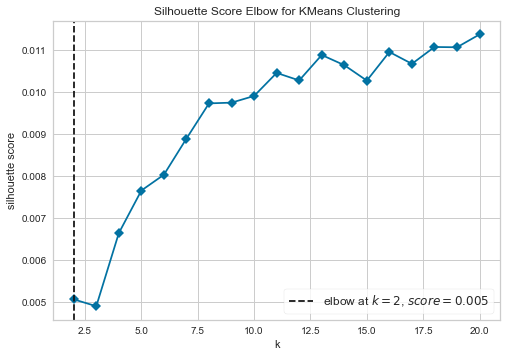

In [14]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,21),metric='silhouette', timings= False )
visualizer.fit(trigram_tfidf_text_vectors)        # Fit the data to the visualizer
visualizer.show(outpath="Kmeans_silhouette_coefficient.png") 

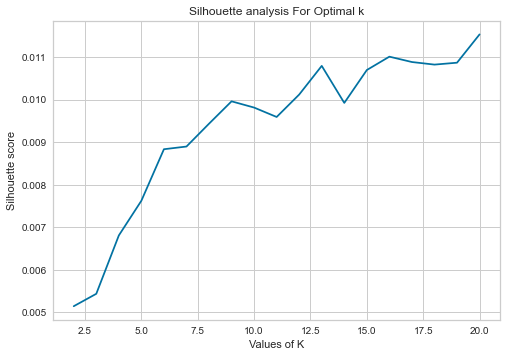

In [15]:
range_n_clusters = np.arange(2,21)
silhouette_avg = []
for num_clusters in range_n_clusters:

    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(trigram_tfidf_text_vectors)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(trigram_tfidf_text_vectors, cluster_labels))
    
    

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

## 3.5 kmeans

In [25]:
number_of_cluster=7

k_means_para = KMeans(n_clusters=number_of_cluster, random_state=42)
k_means_para.fit(trigram_tfidf_text_vectors)

KMeans(n_clusters=7, random_state=42)

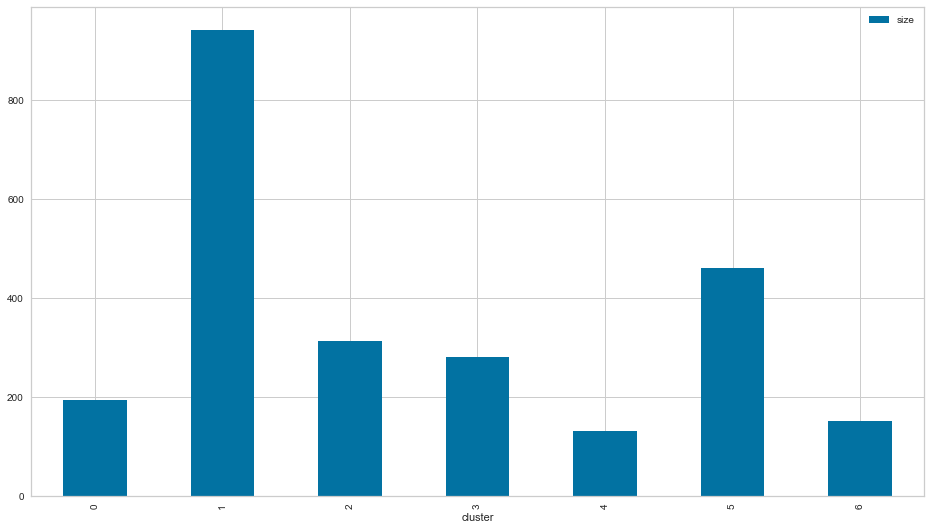

In [26]:
sizes = []
for i in range(number_of_cluster):
    sizes.append({"cluster": i, "size": np.sum(k_means_para.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
plt.savefig("cluster-size.svg")

In [27]:
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'cluster{cluster}.png')

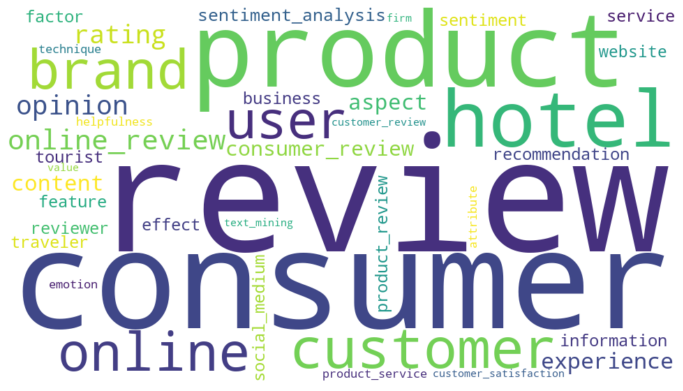

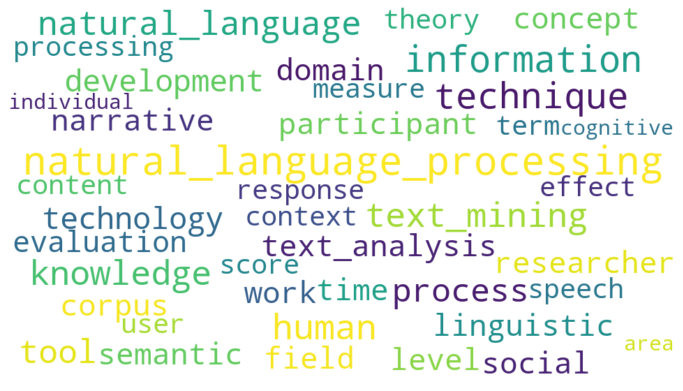

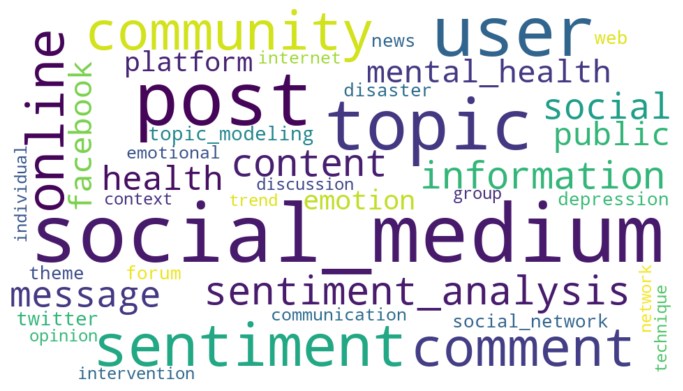

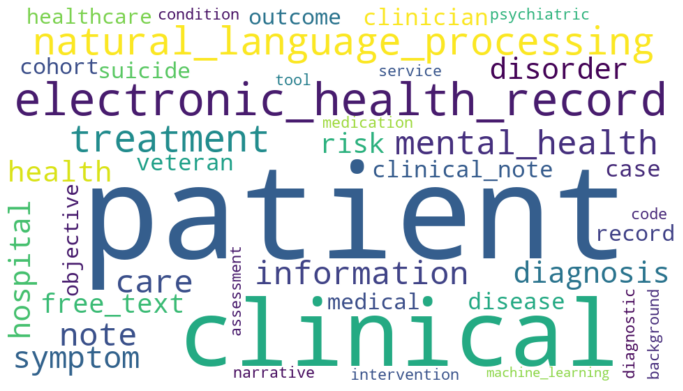

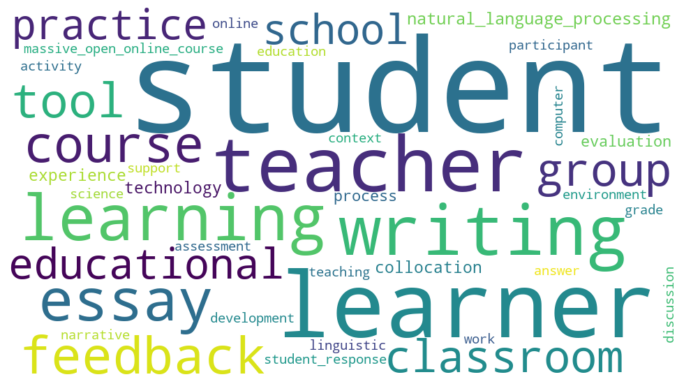

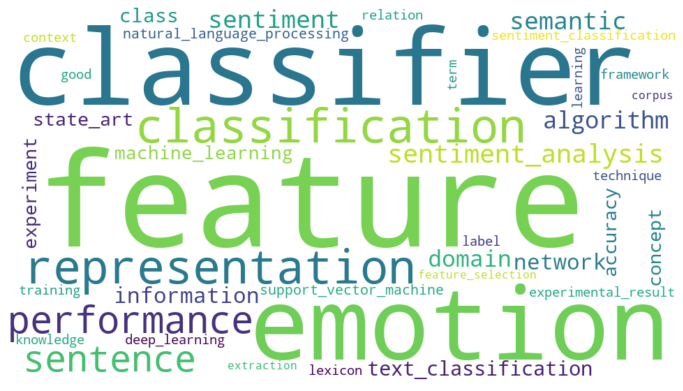

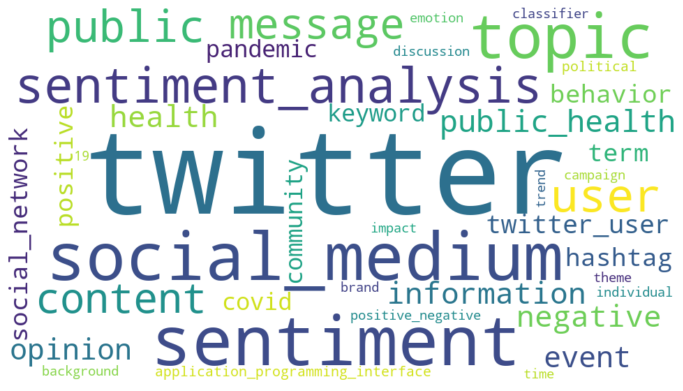

In [28]:
# wordcloud_clusters(k_means_para, tfidf_text_vectors, tfidf_text_vectorizer.get_feature_names())
wordcloud_clusters(k_means_para, trigram_tfidf_text_vectors, tfidf_text_vectorizer.get_feature_names())



In [20]:
df["cluster"]=k_means_para.labels_
df.head()
df.iloc[:,[0,1,2,3,4,-1]].to_excel("df_cluster.xlsx")